In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import itertools
import json
import pickle
import random
import sys

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import model_from_json
from keras import regularizers, optimizers
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import torch
from torchvision.utils import make_grid

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Set path so that functions can be imported from the utils script
sys.path.insert(0, '../')
from preprocess import sample_timeseries
from visualize import visualize_rgb, record_batch
from constants import *
import datasets
import util
import models


Using TensorFlow backend.


In [2]:
train_parser = util.get_train_parser()
args = train_parser.parse_args(['--model_name', 'fcn_crnn', 
                                '--dataset', 'full', 
                                '--num_classes', str(4),
                                '--country', 'ghana',
                                '--hdf5_filepath', '/home/data/ghana/data.hdf5',
                                '--batch_size', str(5),
                                '--hidden_dims', str(32),
                                '--crnn_num_layers', str(1),
                                '--use_s1', str(False),
                                '--use_s2', str(True),
                                '--sample_w_clouds', str(True),
                                '--include_clouds', str(True),
                                '--include_doy', str(True),
                                '--bidirectional', str(False),
                                '--shuffle', str(False)])


In [3]:
show_models = ['cnn', 'nn', 'fcn_crnn', 'rf', 'lr']

fcn_crnn_model_path = '/home/data/ghana/models/best_from_scratch_fcn_crnn'
test_list_pkl = '/home/data/ghana/ghana_full_val'
test_imgs_dir = '/home/data/ghana/s2_npy'
label_dir = '/home/data/ghana/raster_npy'
dates = None
batch = args.batch_size
    

In [4]:
dataloaders = datasets.get_dataloaders('/home/data/ghana', 'ghana', 'full', args=args)
dl = dataloaders['test']
split = 'test'
vis_data = None
vis = None

if 'cnn' in show_models:
    model_json = '/home/data/ghana/models/best_1dcnn_model.json'
    model_hdf5 = '/home/data/ghana/models/best_1dcnn_model.hdf5'

    # load json and create model
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model_cnn = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model_cnn.load_weights(model_hdf5)
    print("Loaded model from disk")
    # evaluate loaded model on test data
    loaded_model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
if 'nn' in show_models:
    model_json = '/home/data/ghana/models/best_1dnn_model.json'
    model_hdf5 = '/home/data/ghana/models/best_1dnn_model.hdf5'

    # load json and create model
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model_nn = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model_nn.load_weights(model_hdf5)
    print("Loaded model from disk")
    # evaluate loaded model on test data
    loaded_model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

if 'rf' in show_models:
    filename = '/home/data/ghana/models/random_forest_model'
    loaded_model_rf = pickle.load(open(filename, 'rb'))
    
if 'lr' in show_models:
    filename = '/home/data/ghana/models/logistic_regression_model'
    loaded_model_lr = pickle.load(open(filename, 'rb'))
    
X_train = np.load('/home/data/ghana/pixel_arrays/full/raw/full_raw_s2_cloud_mask_reverseFalse_bytime_Xtrain_g2260.npy')
# Normalize by standard scalar
scaler = StandardScaler()
scaler.fit(X_train)
        
with open(test_list_pkl, 'rb') as f:
    test_grids = pickle.load(f)
    
test_fnames = [os.path.join(test_imgs_dir,f) for f in os.listdir(test_imgs_dir) if f[9:15] in test_grids and f.endswith('.npy')]
test_fnames.sort()


Loaded model from disk
Loaded model from disk


/home/croptype/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.0 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/croptype/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.0 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/croptype/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:

if 'fcn_crnn' in show_models:
    model_name = 'fcn_crnn'
    fcn_crnn_model = models.get_model(**vars(args))
    fcn_crnn_model.load_state_dict(torch.load(fcn_crnn_model_path))
    fcn_crnn_model.eval()
  
    batch_num = 0
    for inputs, targets, cloudmasks in dl:
        preds = fcn_crnn_model(inputs)
        labels_grid, inputs_grid, targets_grid, preds_grid, predsmask_grid = record_batch(
                                                                           inputs, cloudmasks, targets, preds, #<< preds
                                                                           args.num_classes, split, vis_data, 
                                                                           vis, args.include_doy, args.use_s1, 
                                                                           args.use_s2, model_name, args.time_slice, 
                                                                           save=False, save_dir=None, 
                                                                           show_visdom=False, show_matplot=True)
        
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(labels_grid, (1, 2, 0)))
        plt.title('labels')
        plt.show()
        
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(inputs_grid, (1, 2, 0)))
        plt.title('inputs')
        plt.show()
    
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(targets_grid, (1, 2, 0)))
        plt.title('targets')
        plt.show()
        
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(preds_grid, (1, 2, 0)))
        plt.title('FCN CRNN predictions')
        plt.show()
        
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(predsmask_grid, (1, 2, 0)))
        plt.title('FCN CRNN predictions with mask')
        plt.show()
        
        if 'cnn' in show_models or 'rf' in show_models:
            idx = batch_num #for idx in range(0, len(test_fnames), batch*2):
            num_in_batch = 0
            cur_batch_imgs_cnn = []
            cur_batch_imgs_rf = []
            while num_in_batch < 2*batch:
        
                s2_img = np.load(test_fnames[idx+num_in_batch])
                clouds = np.load(test_fnames[idx+num_in_batch+1])
                s2_img, _, clouds = sample_timeseries(s2_img, 25, dates, clouds) #, seed=1234)
                clouds = np.expand_dims(clouds, 0)
    
                all_data = np.concatenate((s2_img, clouds), axis=0)
    
                data = np.transpose(all_data, (1, 2, 3, 0))
                data = np.reshape(data, (-1, 275))
                data = scaler.transform(data)
                data = np.reshape(data, (64*64, -1, 11))                            
                
                if 'cnn' in show_models:
                    pred_cnn = np.argmax(loaded_model.predict(data), axis=1) + 1
                    pred_cnn = np.reshape(pred_cnn, (1, 1, 64, 64))
                    pred_cnn = visualize_rgb(pred_cnn, num_classes=4)
                    cur_batch_imgs_cnn.append(pred_cnn)
                    
                if 'rf' in show_models:
                    data = np.transpose(data, (0, 2, 1))
                    data = np.reshape(data, (64*64, -1))
                    pred_rf = np.argmax(loaded_model_rf.predict(data), axis=1) + 1
                    pred_rf = np.reshape(pred_rf, (1, 1, 64, 64))
                    pred_rf = visualize_rgb(pred_rf, num_classes=4)
                    cur_batch_imgs_rf.append(pred_cnn)
                    
                num_in_batch += 2
        
            batch_num += batch*2
            
            if 'cnn' in show_models:
                cur_batch_imgs_cnn = np.concatenate(cur_batch_imgs_cnn, axis=0)
                cur_batch_grid_cnn = make_grid(torch.from_numpy(cur_batch_imgs_cnn), nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=255)
                cur_batch_grid_cnn = np.transpose(cur_batch_grid_cnn, (1, 2, 0))
    
                plt.figure(figsize=(10,10))
                plt.imshow(cur_batch_grid_cnn)
                plt.title('1D CNN predictions')
                plt.show() 

                plt.figure(figsize=(10,10))
                plt.imshow(cur_batch_grid_cnn * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
                plt.title('1D CNN predictions masked')
                plt.show()
                
            if 'rf' in show_models:
                
                cur_batch_imgs_rf = np.concatenate(cur_batch_imgs_rf, axis=0)
                cur_batch_grid_rf = make_grid(torch.from_numpy(cur_batch_imgs_rf), nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=255)
                cur_batch_grid_rf = np.transpose(cur_batch_grid_rf, (1, 2, 0))
    
                plt.figure(figsize=(10,10))
                plt.imshow(cur_batch_grid_rf)
                plt.title('Random Forest predictions')
                plt.show() 

                plt.figure(figsize=(10,10))
                plt.imshow(cur_batch_grid_rf * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
                plt.title('Random Forest predictions masked')
                plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


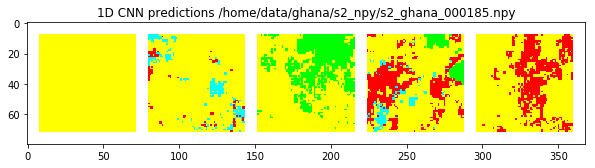

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


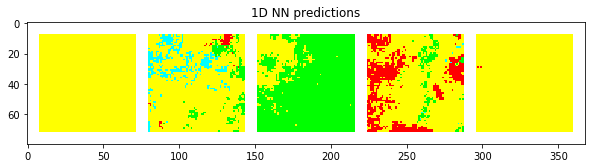

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


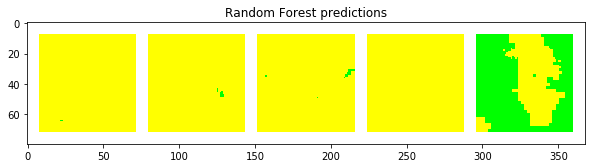

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


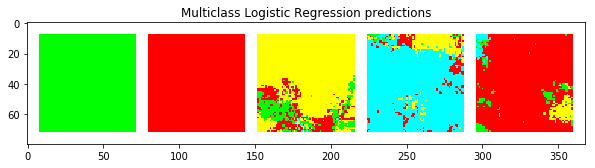

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


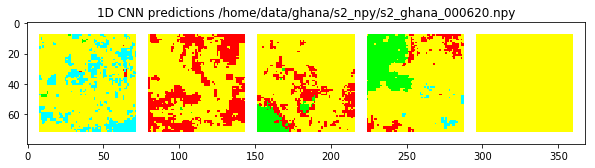

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


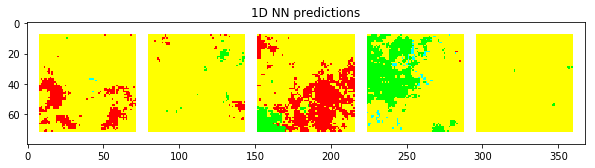

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


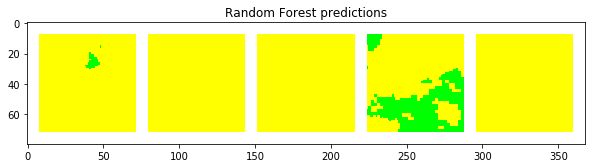

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


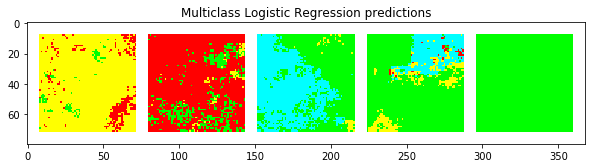

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


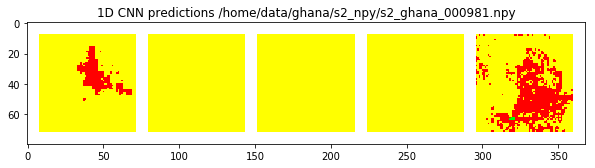

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


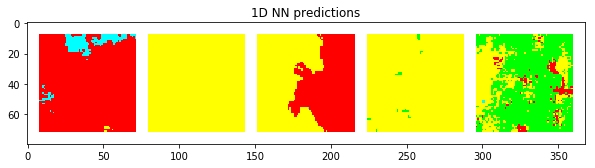

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


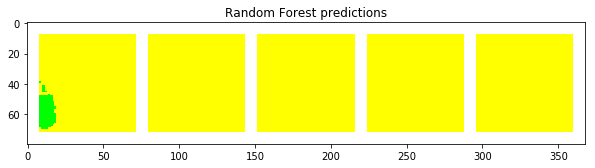

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


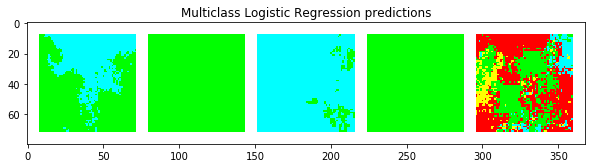

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


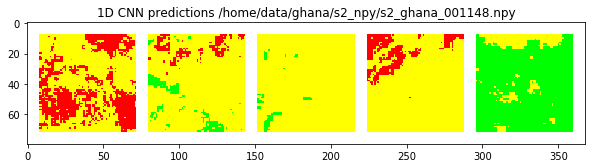

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


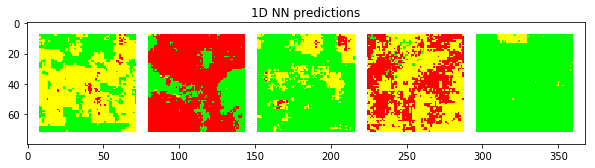

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


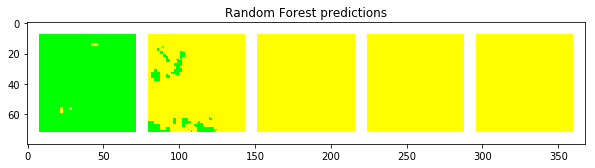

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


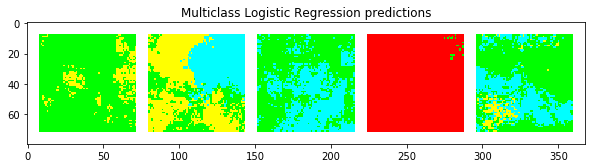

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


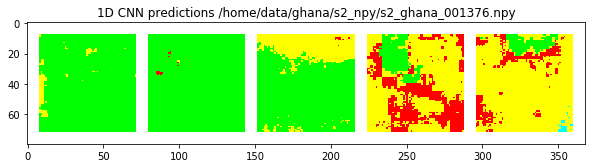

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


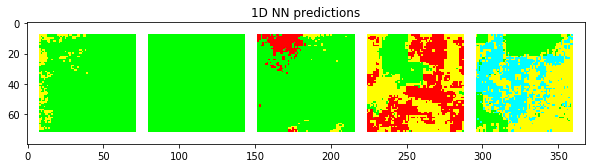

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


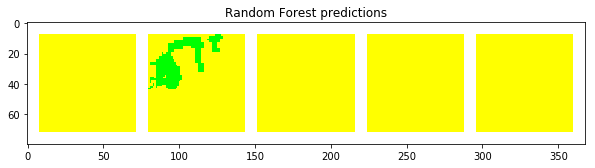

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


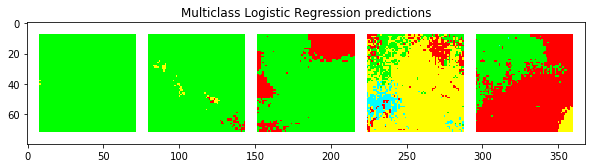

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


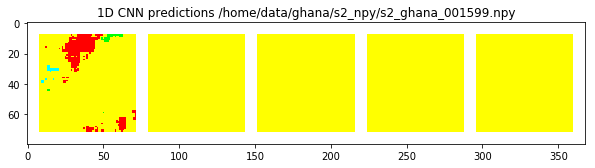

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


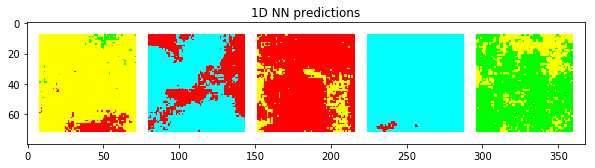

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


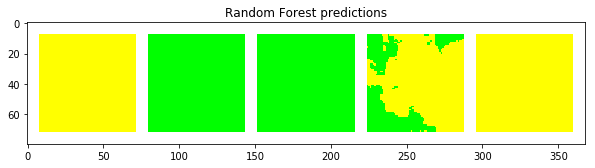

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


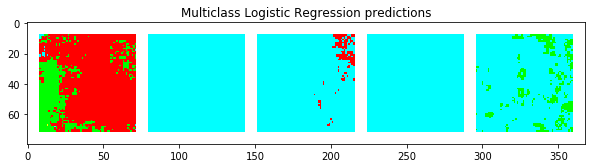

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


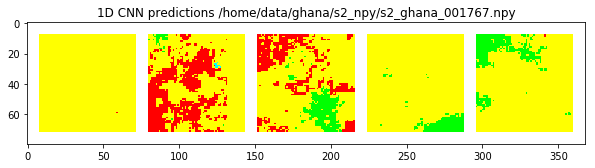

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


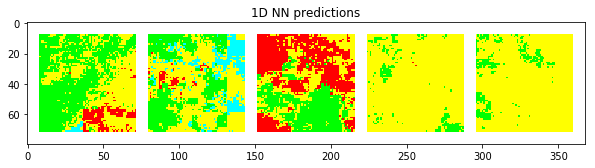

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


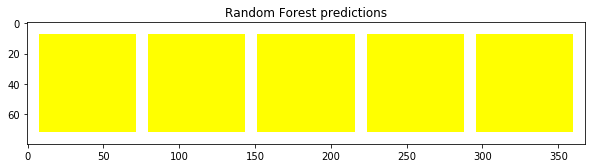

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


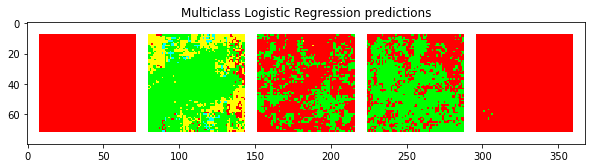

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


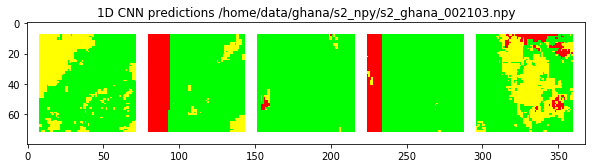

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


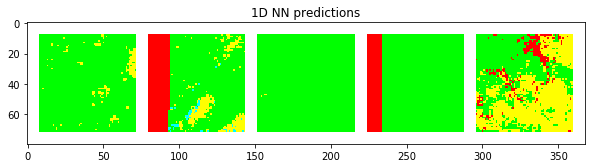

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


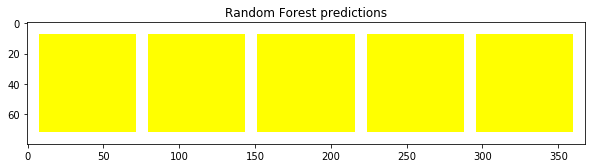

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


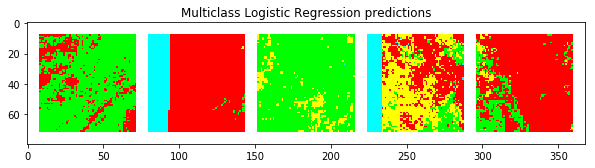

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


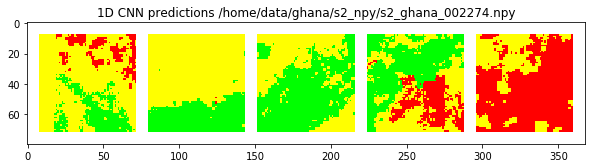

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


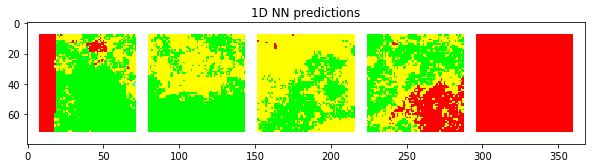

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


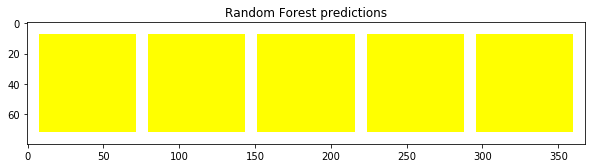

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


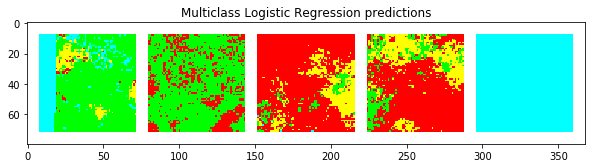

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


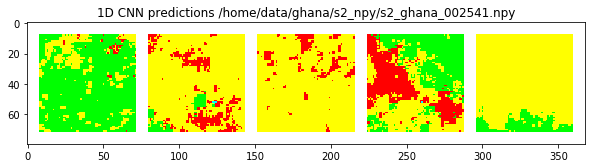

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


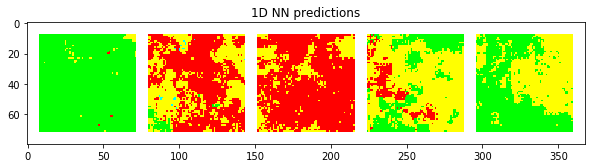

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


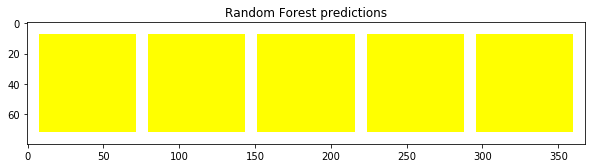

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


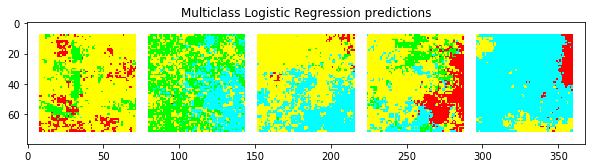

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


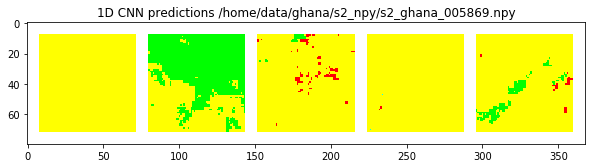

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


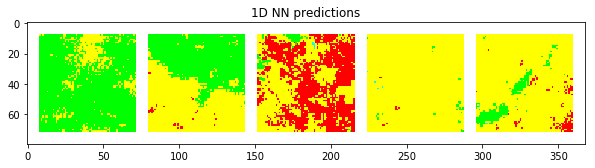

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


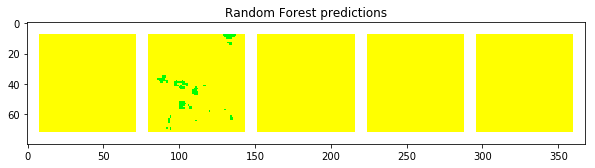

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


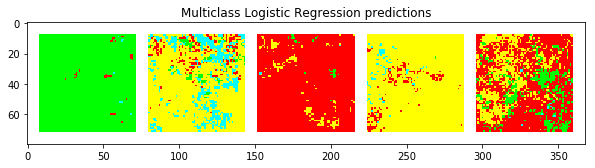

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


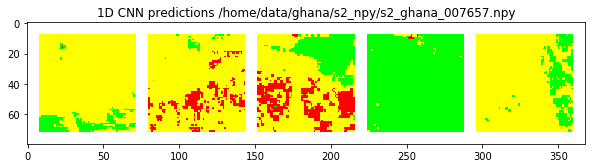

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


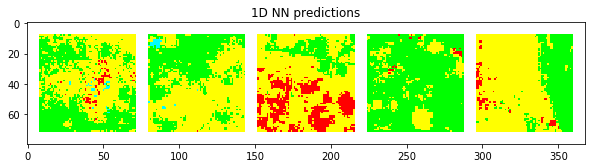

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


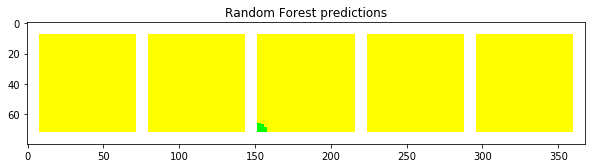

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


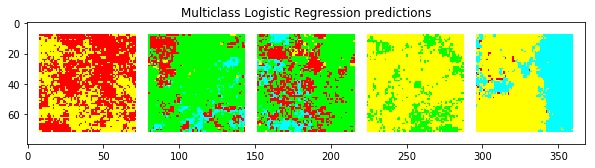

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


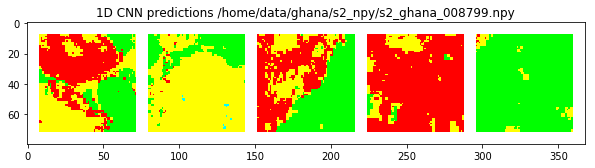

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


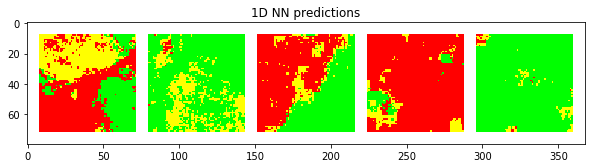

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


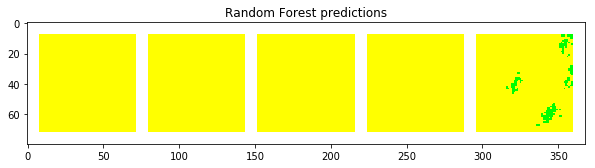

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


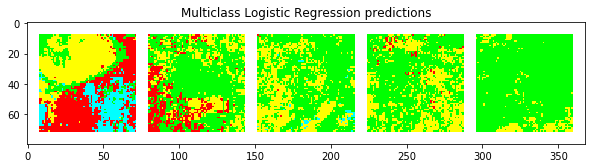

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


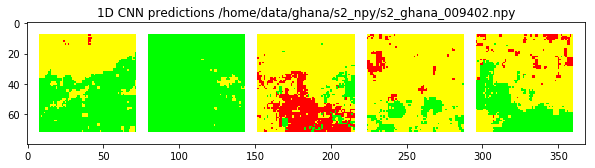

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


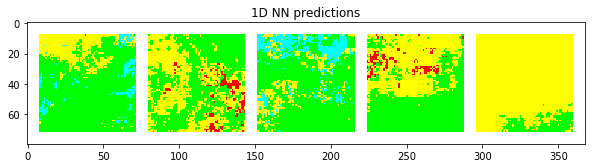

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


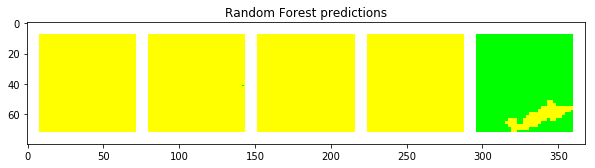

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


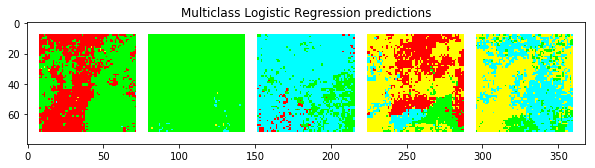

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


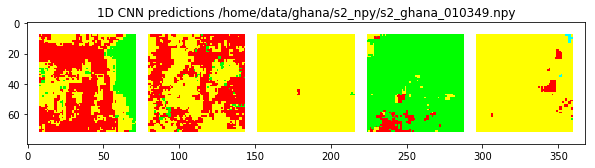

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


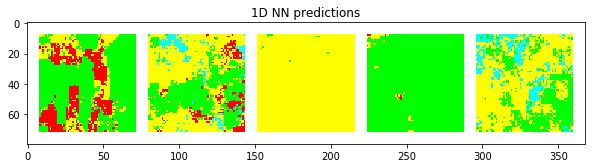

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


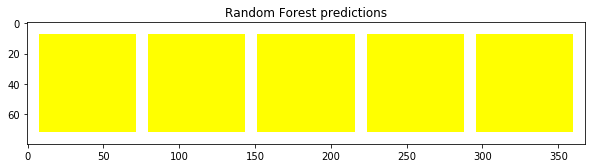

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


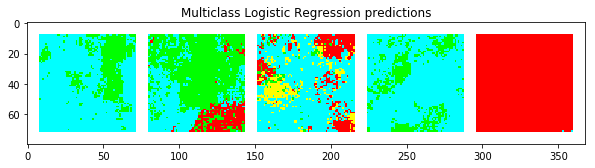

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


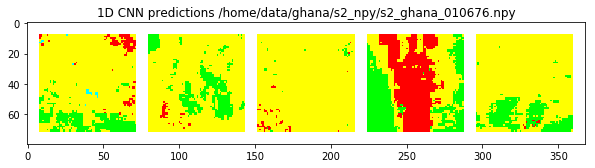

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


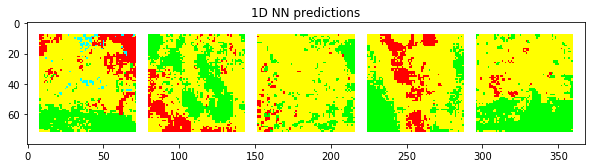

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


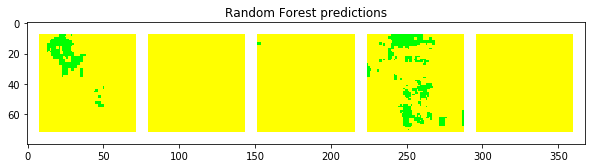

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


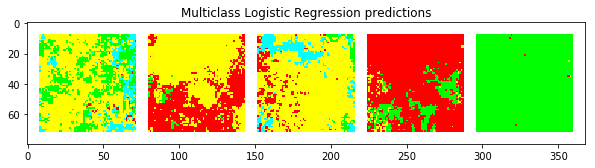

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


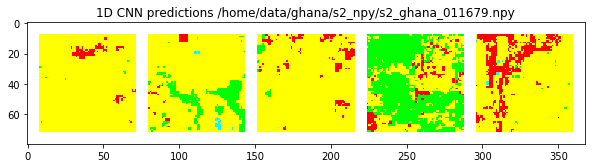

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


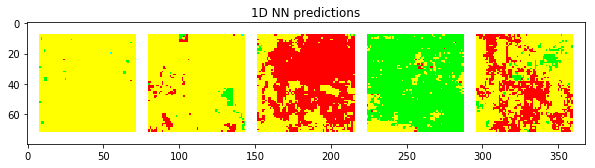

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


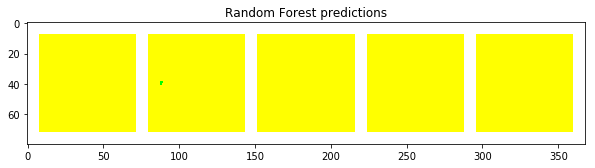

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


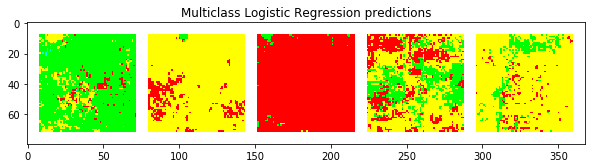

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


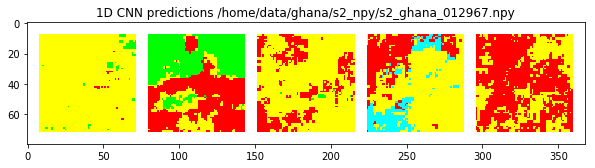

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


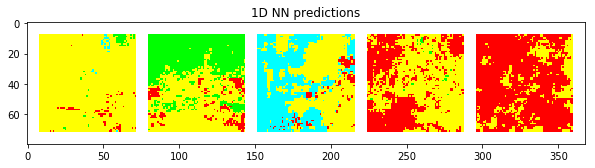

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


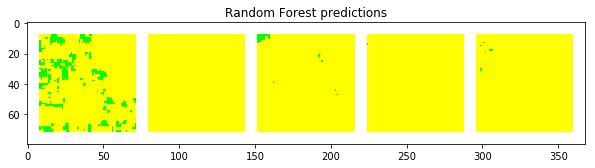

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


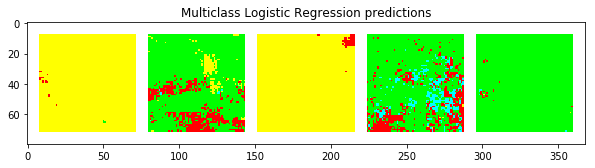

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


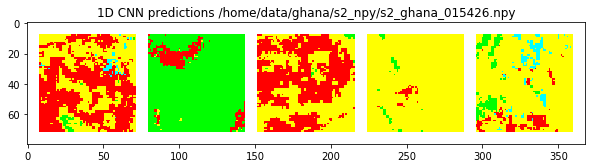

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


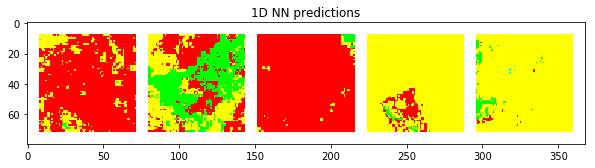

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


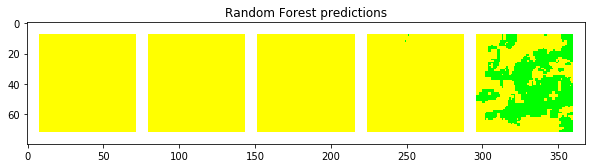

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


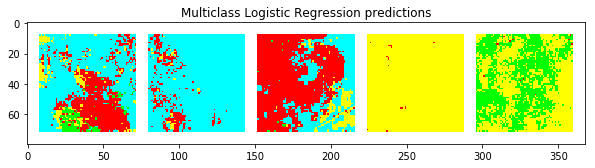

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


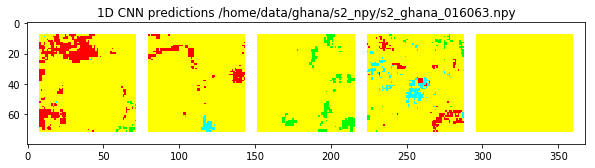

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


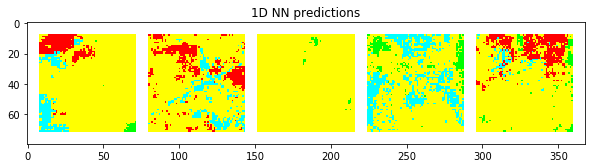

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


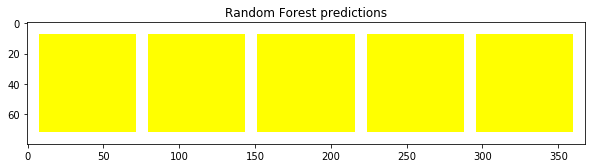

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


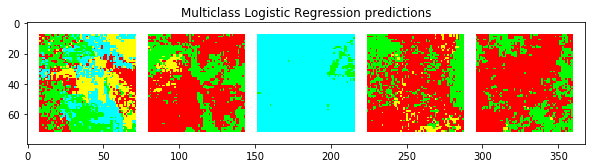

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


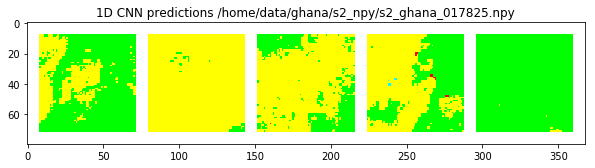

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


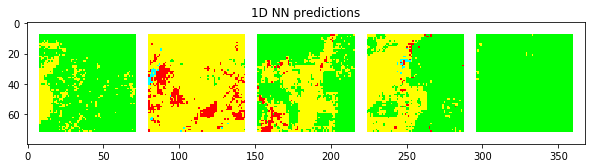

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


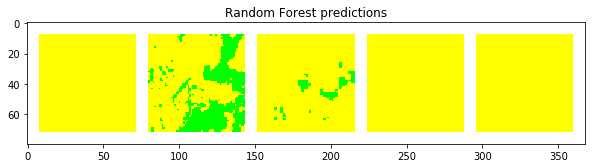

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


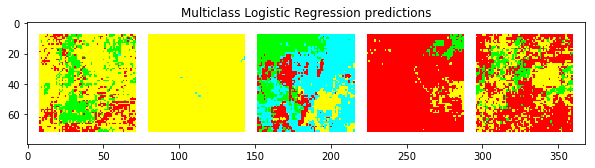

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


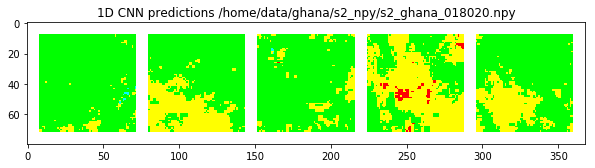

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


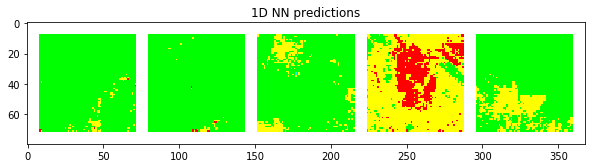

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


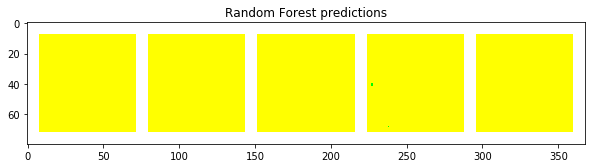

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


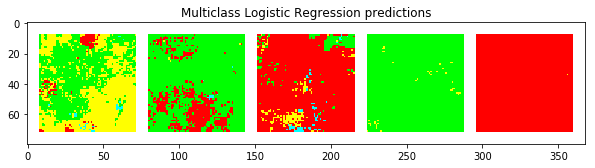

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


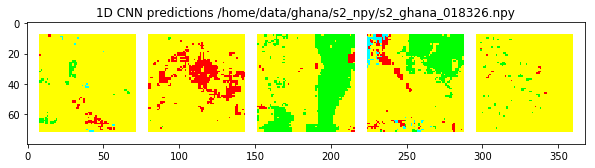

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


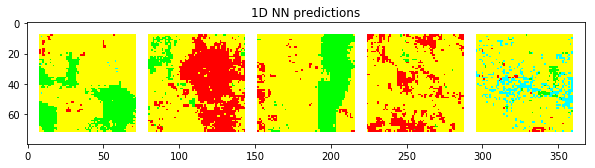

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


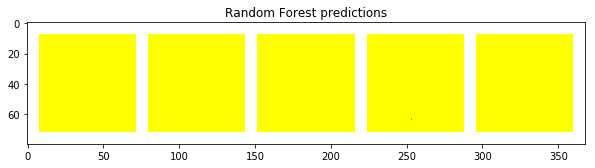

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


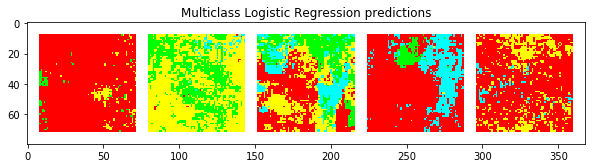

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


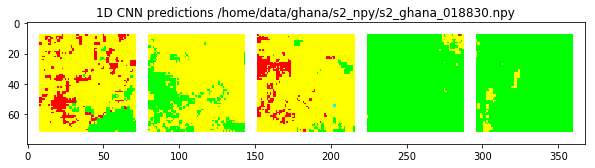

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


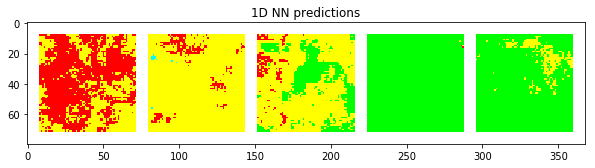

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


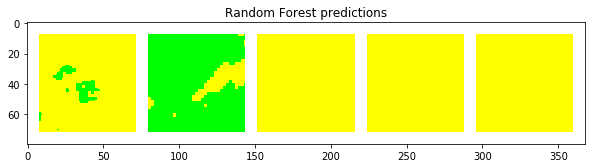

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


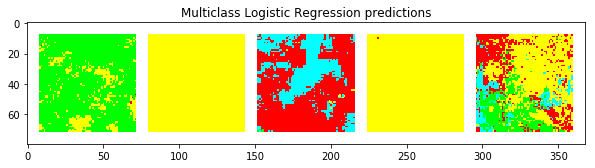

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


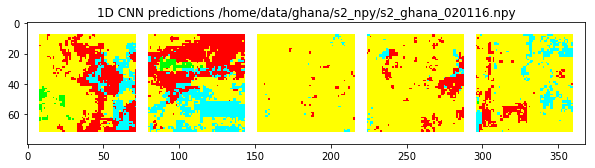

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


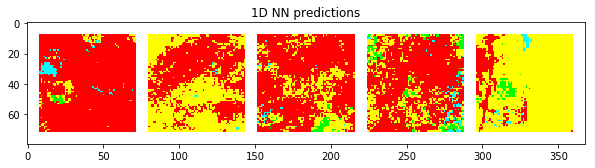

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


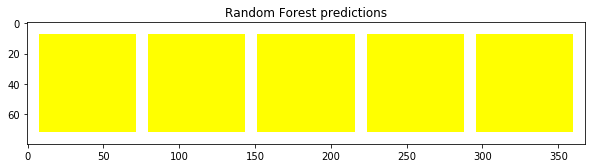

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


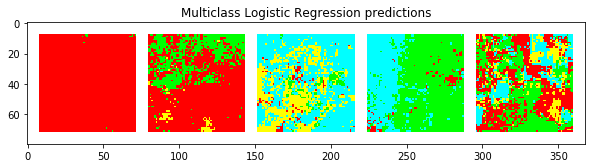

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


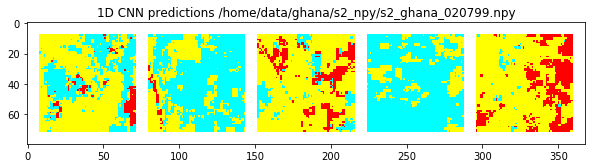

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


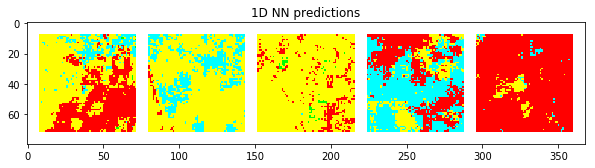

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


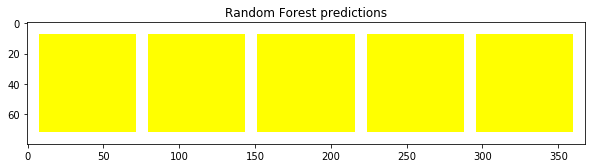

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


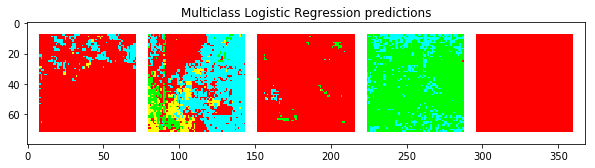

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


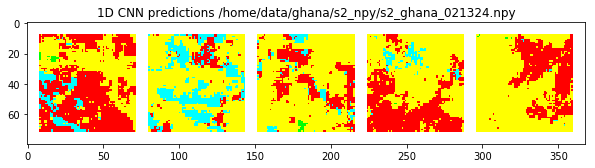

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


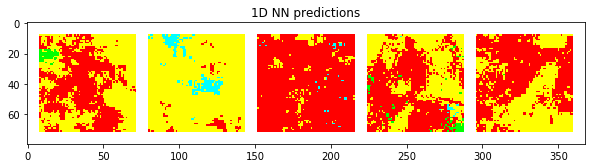

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


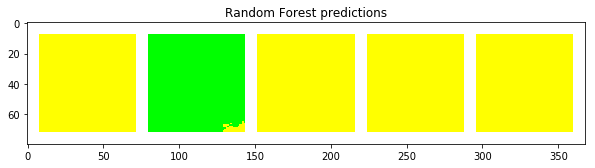

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


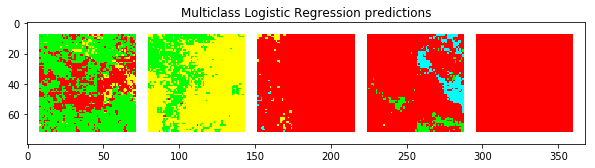

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


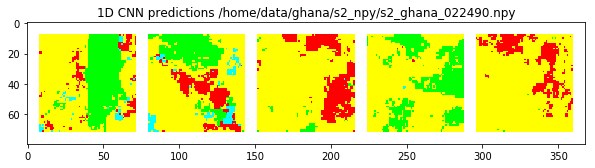

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


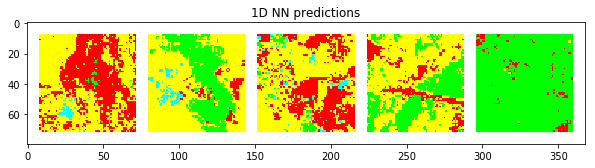

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


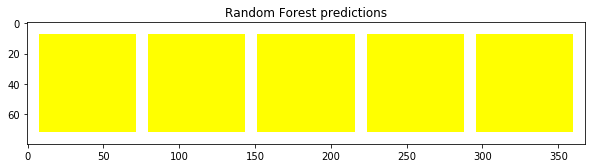

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


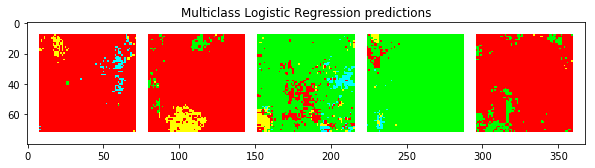

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


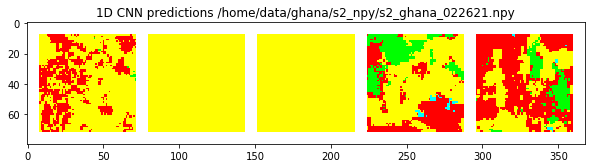

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


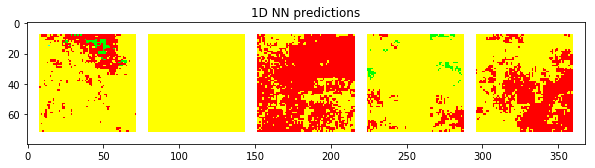

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


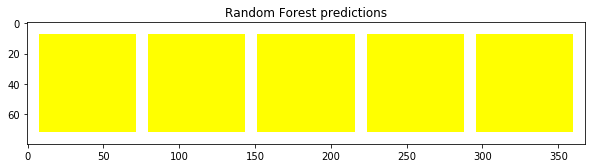

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


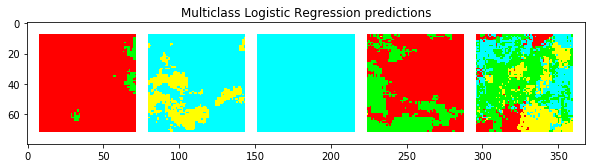

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


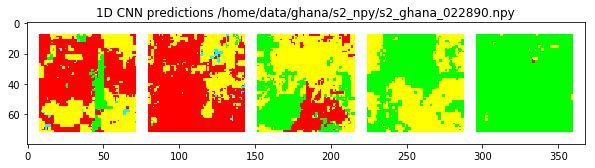

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


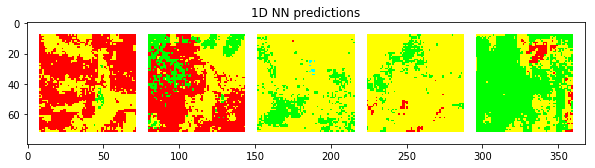

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


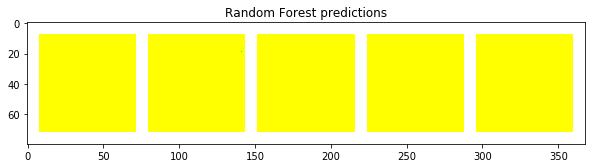

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


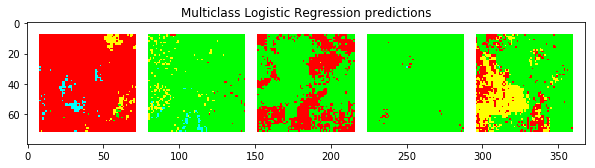

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


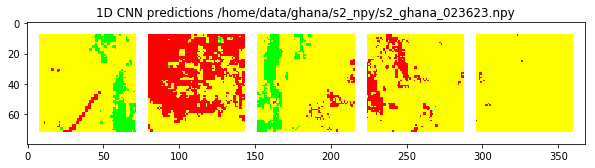

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


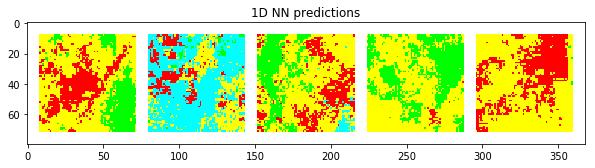

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


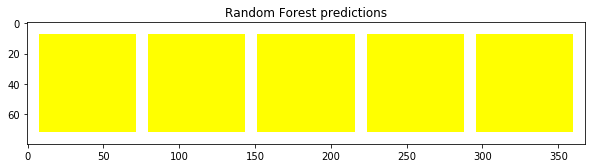

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


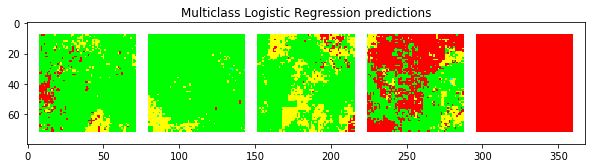

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


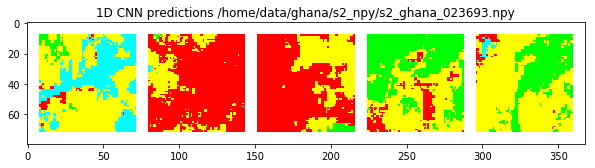

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


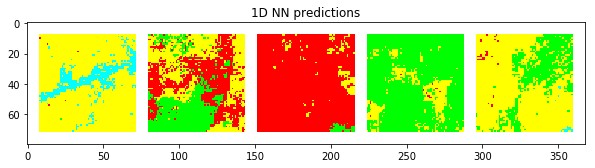

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


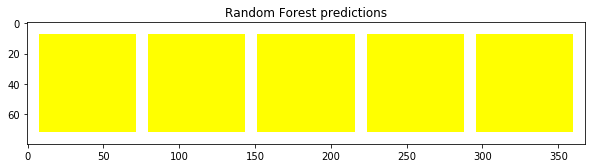

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


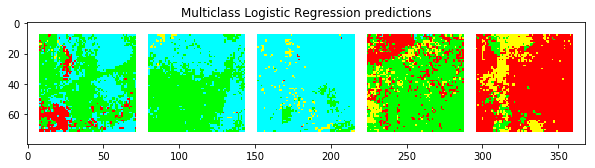

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


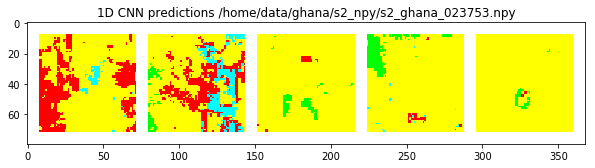

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


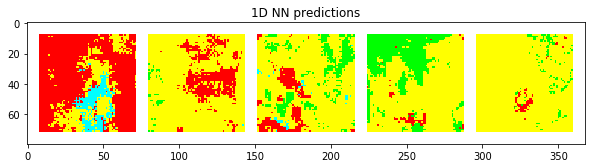

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


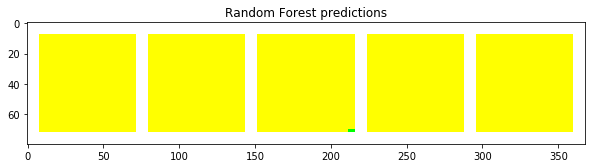

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


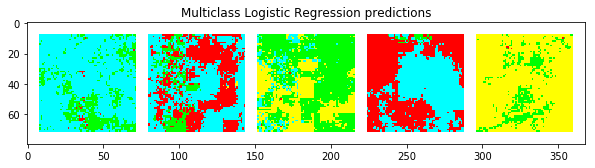

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


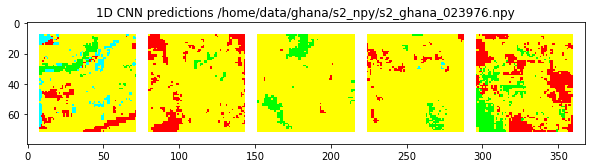

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


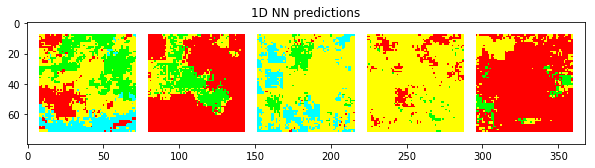

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


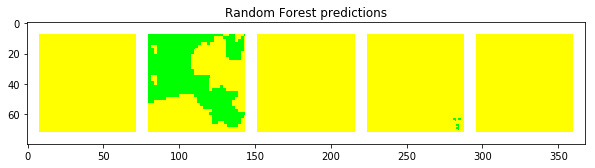

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


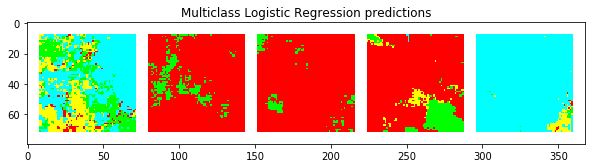

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


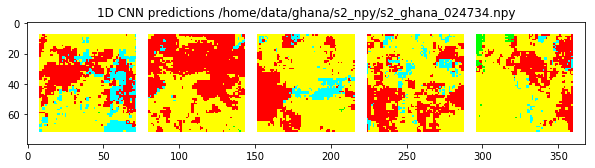

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


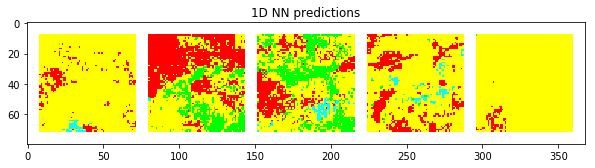

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


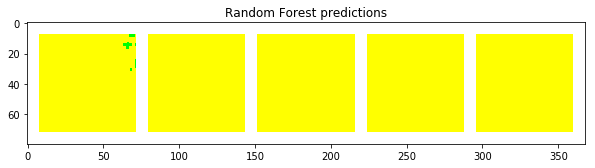

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


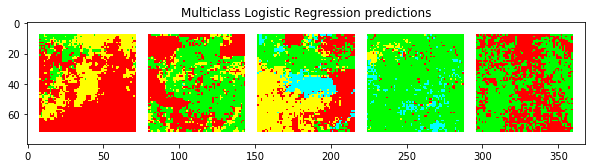

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


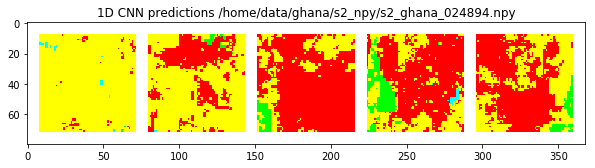

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


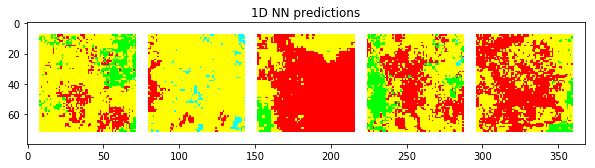

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


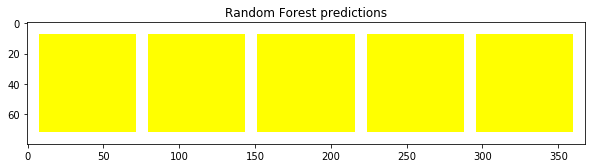

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


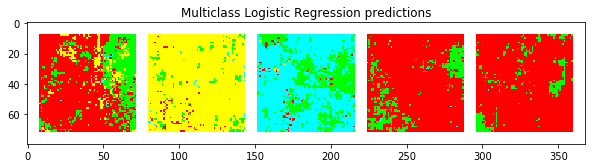

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


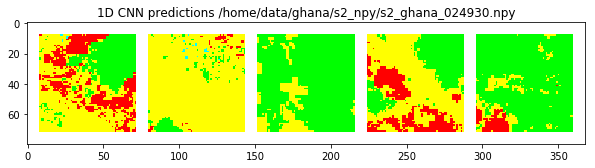

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


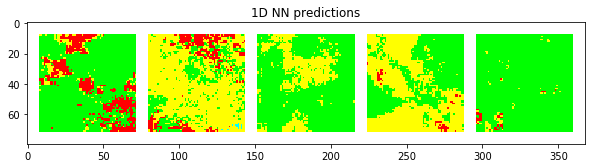

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


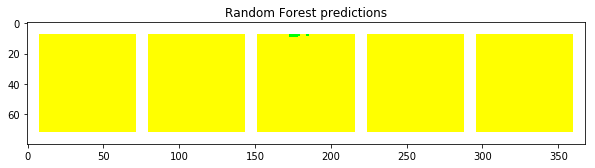

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


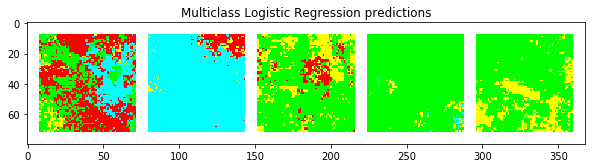

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


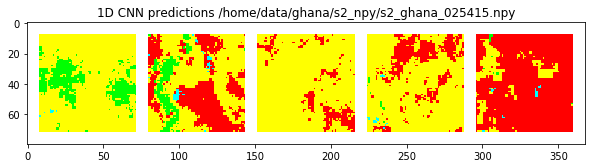

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


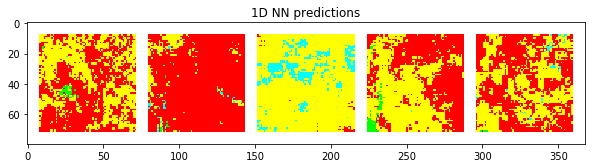

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


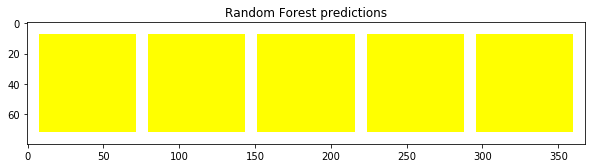

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


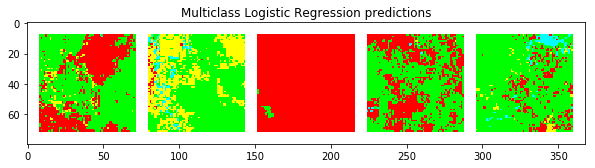

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


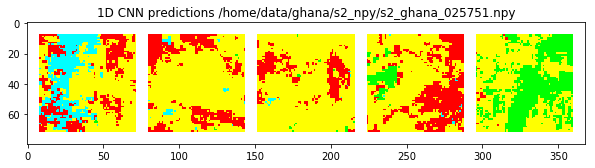

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


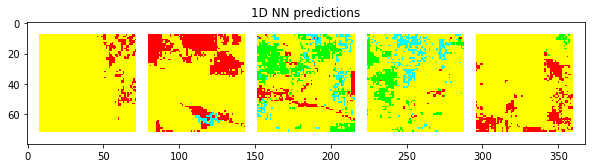

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


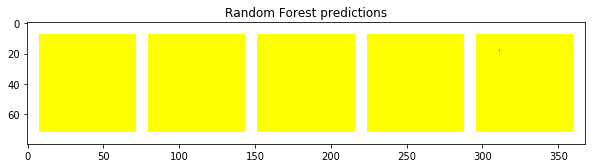

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


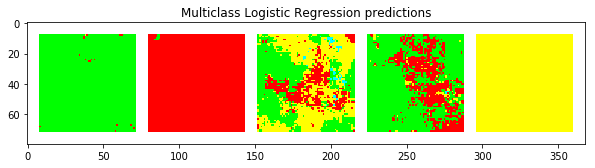

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


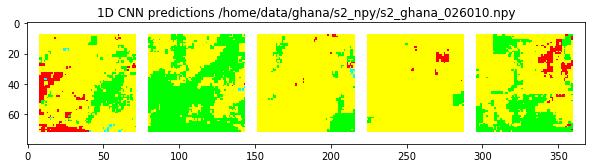

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


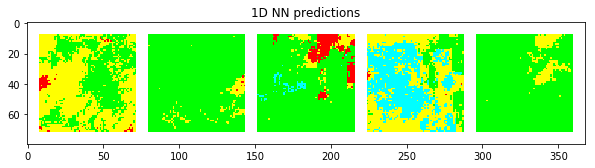

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


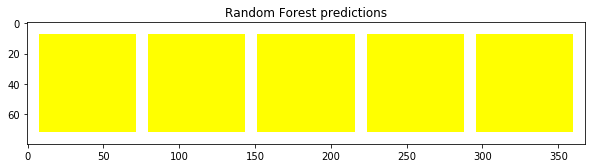

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


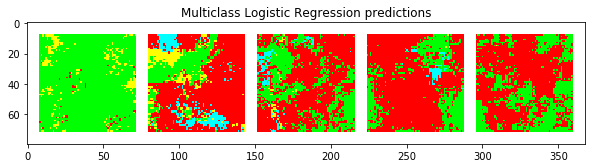

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


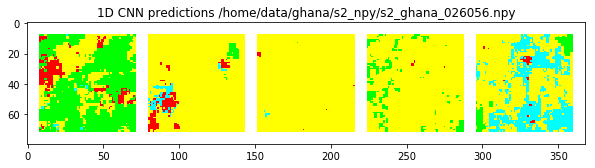

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


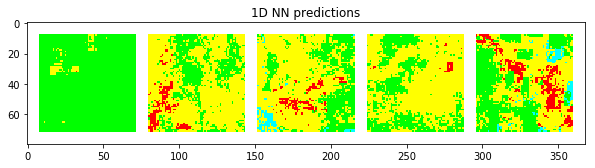

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


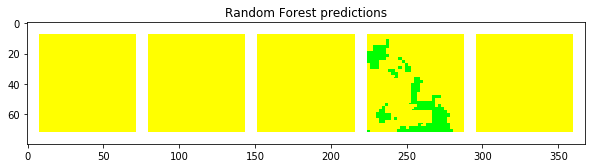

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


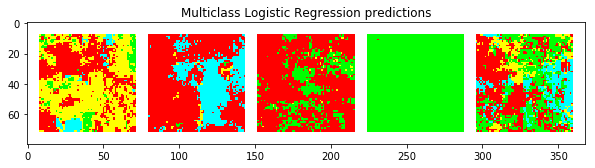

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


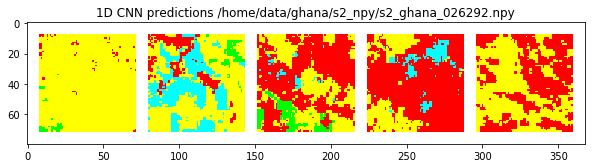

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


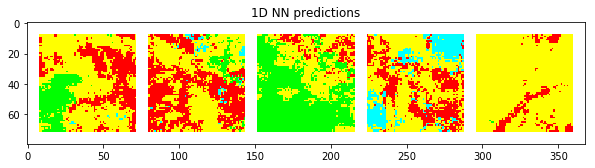

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


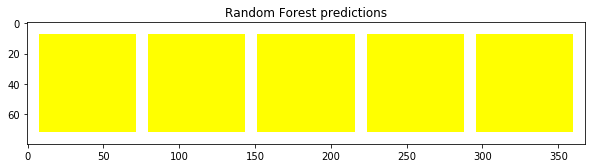

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


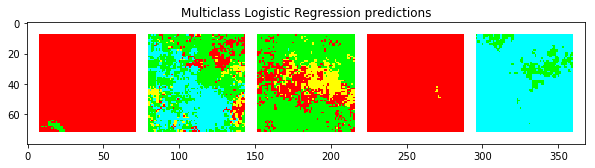

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


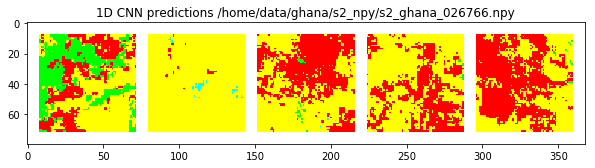

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


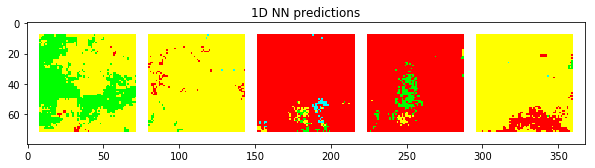

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


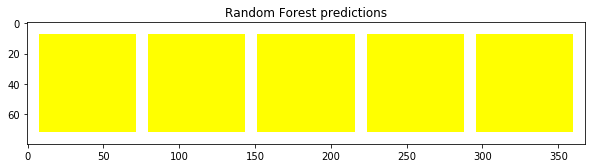

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


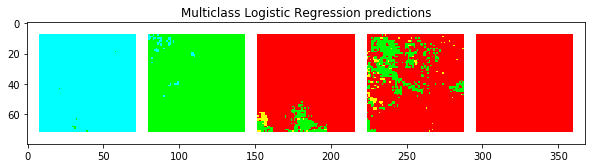

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


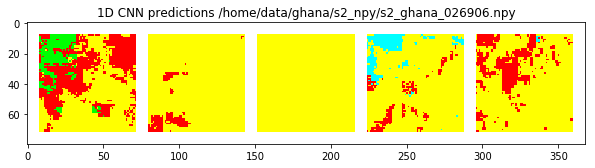

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


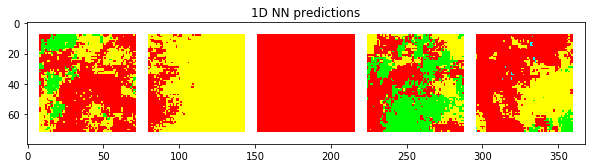

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


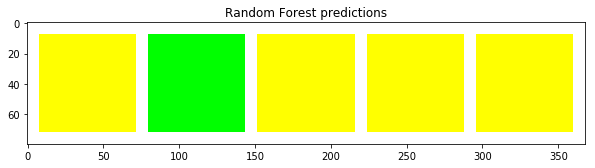

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


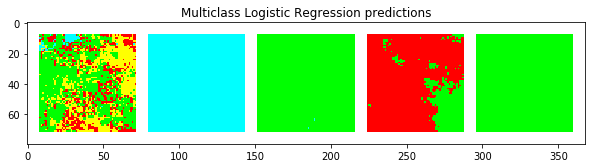

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


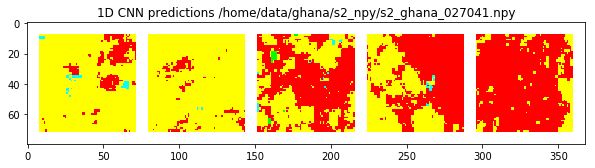

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


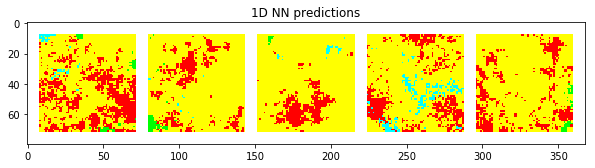

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


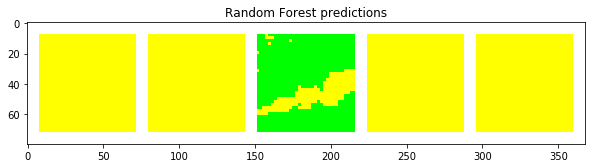

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


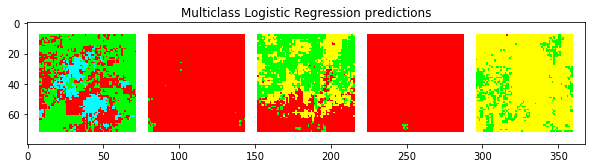

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


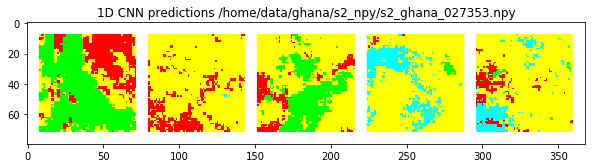

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


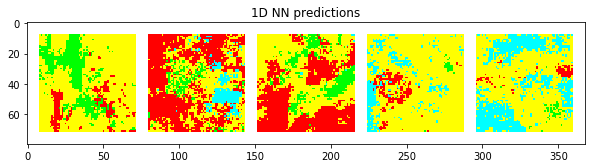

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


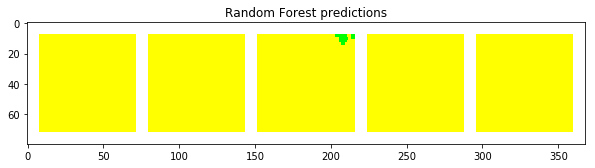

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


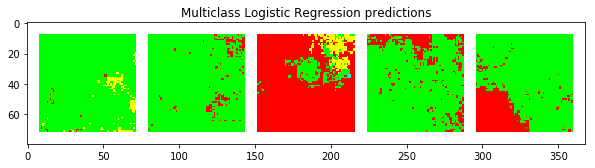

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


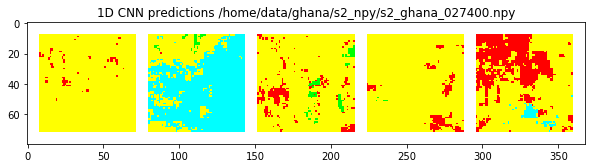

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


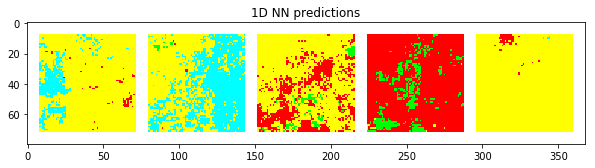

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


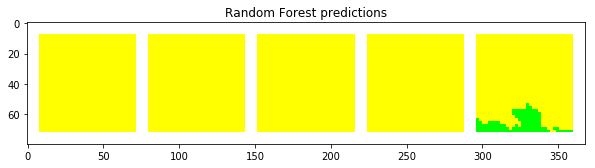

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


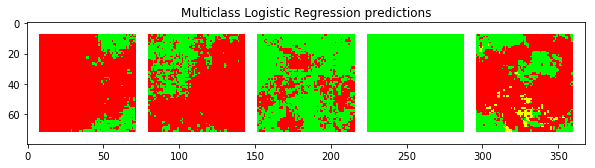

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


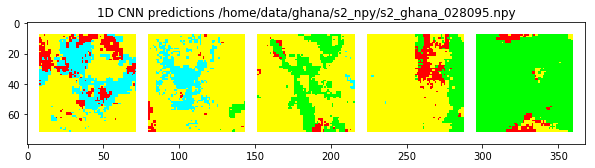

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


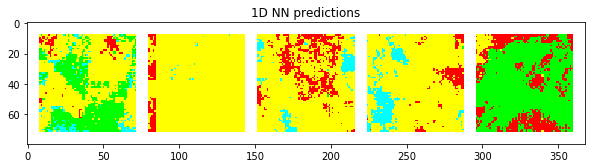

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


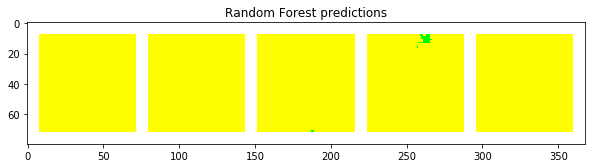

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


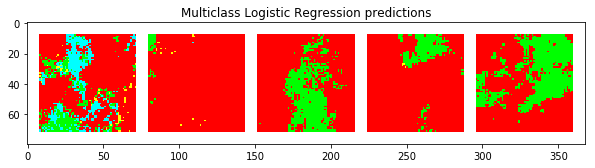

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


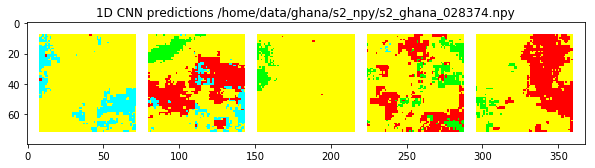

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


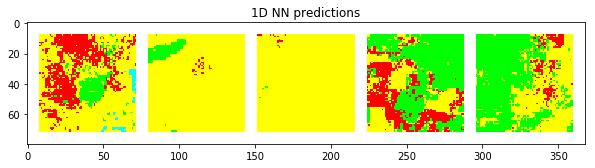

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


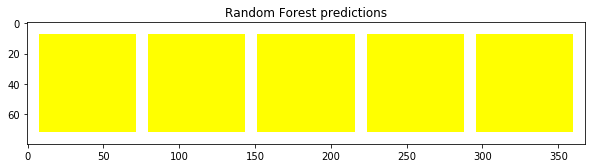

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


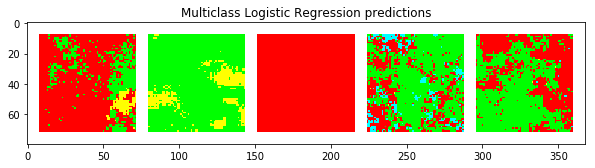

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


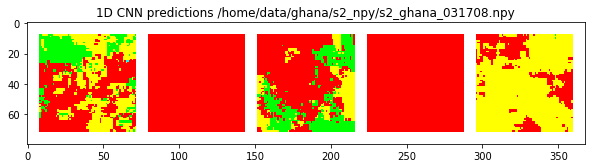

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


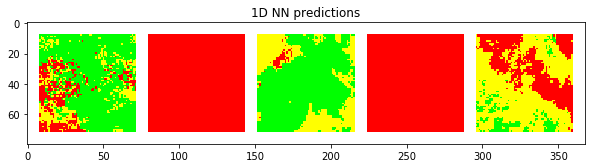

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


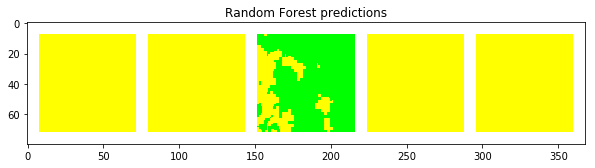

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


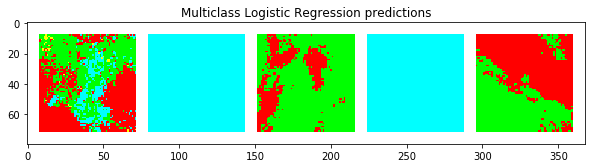

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


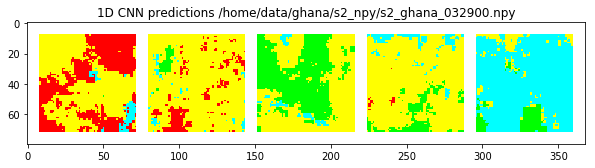

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


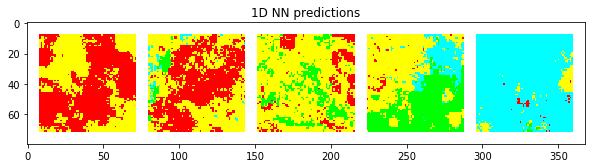

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


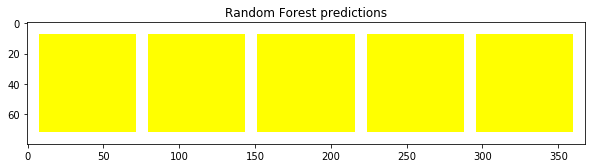

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


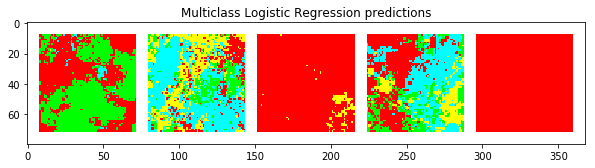

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


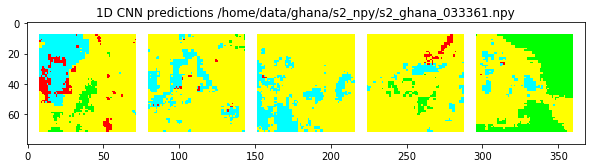

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


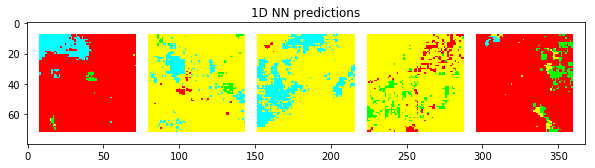

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


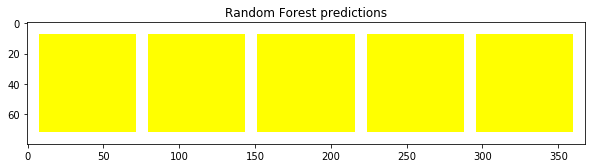

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


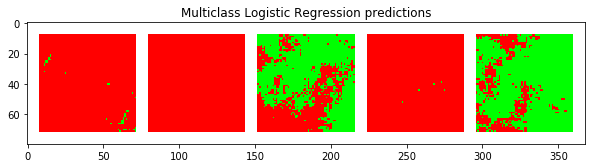

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


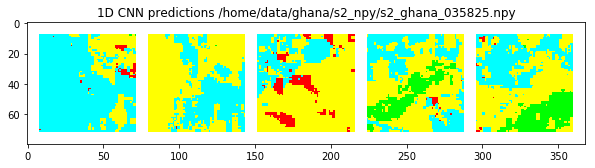

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


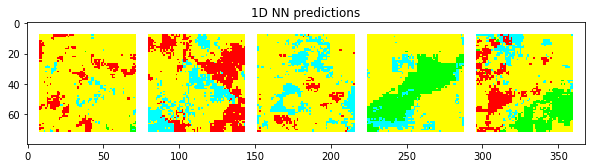

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


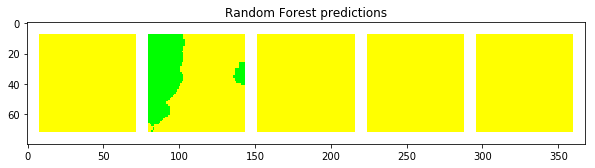

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


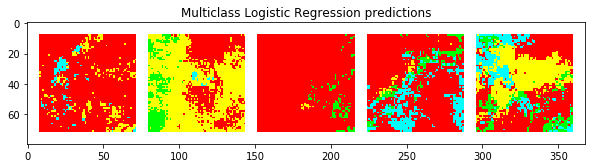

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


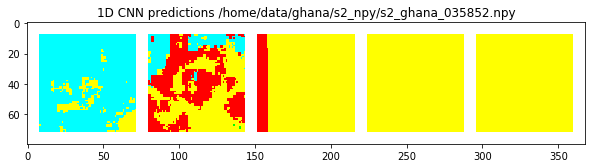

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


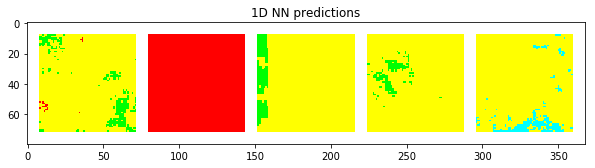

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


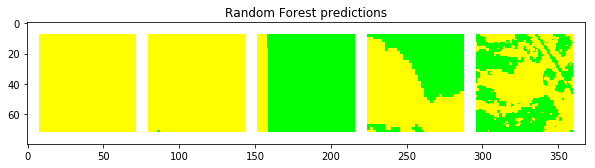

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


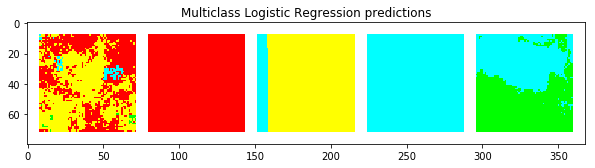

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


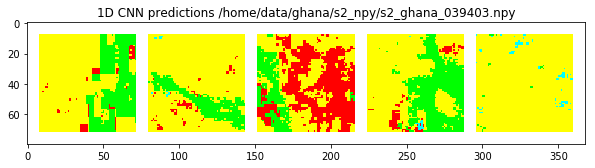

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


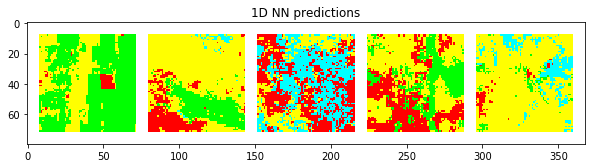

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


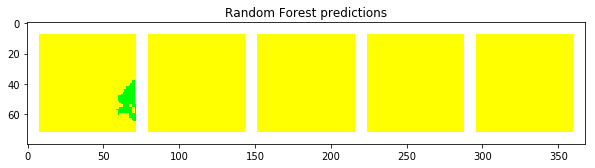

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


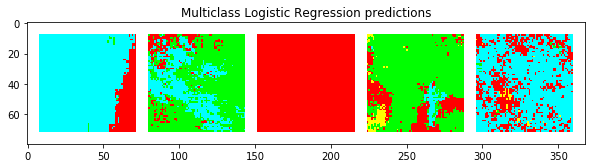

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


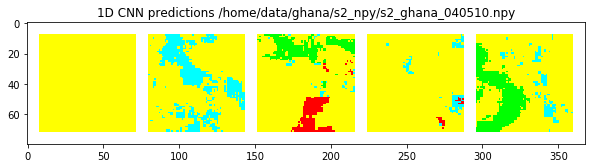

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


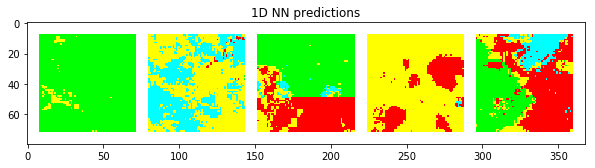

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


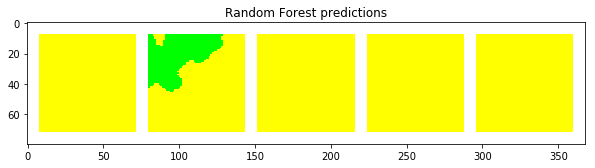

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


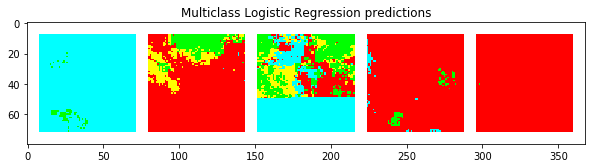

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


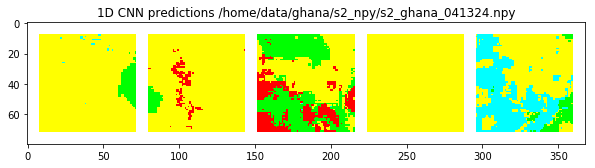

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


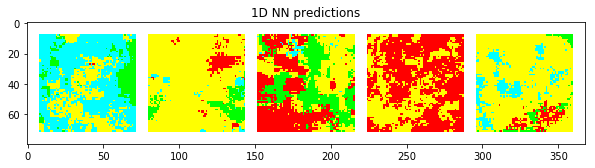

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


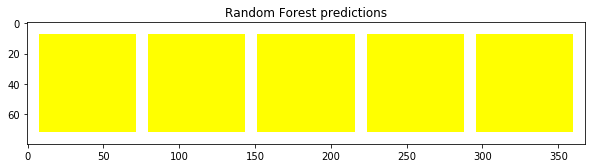

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


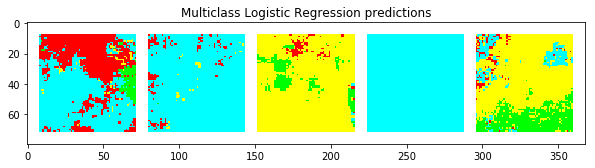

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


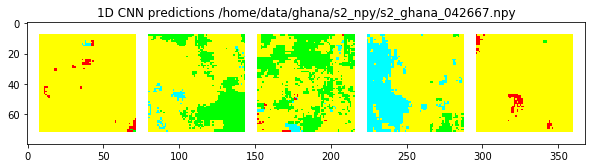

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


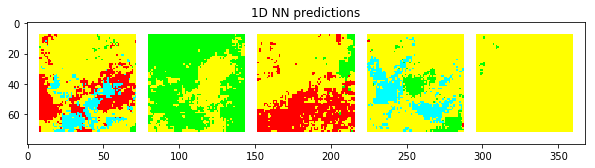

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


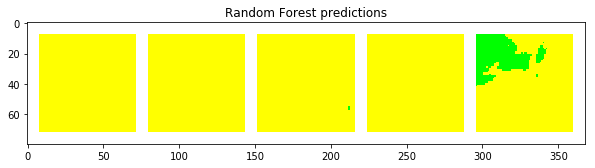

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


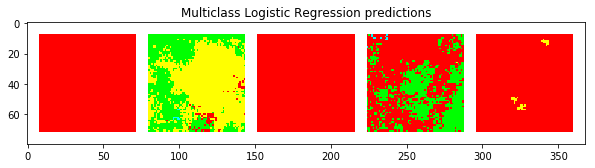

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


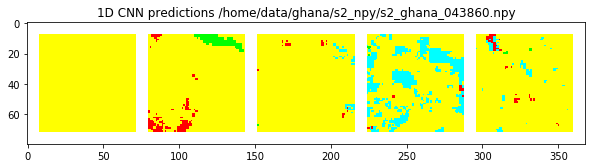

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


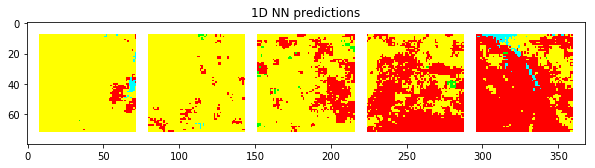

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


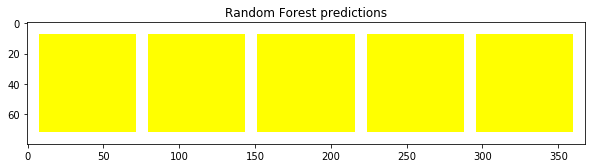

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


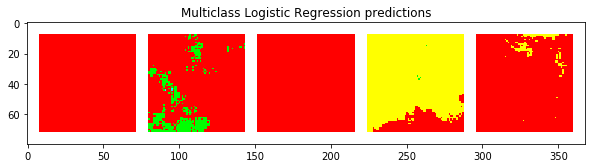

IndexError: list index out of range

In [8]:
test_fnames.sort()
batch_num = 0
while batch_num < len(test_fnames):
    if 'cnn' in show_models or 'nn' in show_models or 'rf' in show_models or 'lr' in show_models:
        idx = batch_num #for idx in range(0, len(test_fnames), batch*2):
        num_in_batch = 0
        cur_batch_imgs_cnn = []
        cur_batch_imgs_nn = []
        cur_batch_imgs_rf = []
        cur_batch_imgs_lr = []
        while num_in_batch < 2*batch:
        
            s2_img = np.load(test_fnames[idx+num_in_batch])
            clouds = np.load(test_fnames[idx+num_in_batch+1])
            s2_img, _, clouds = sample_timeseries(s2_img, 25, dates, clouds) #, seed=1234)
            clouds = np.expand_dims(clouds, 0)
    
            all_data = np.concatenate((s2_img, clouds), axis=0)
    
            data = np.transpose(all_data, (1, 2, 3, 0))
            data = np.reshape(data, (-1, 275))
            data_in = scaler.transform(data)                         
                
            if 'cnn' in show_models:
                data = np.reshape(data_in, (64*64, -1, 11))     
                pred_cnn = np.argmax(loaded_model_cnn.predict(data), axis=1) + 1
                pred_cnn = np.reshape(pred_cnn, (1, 1, 64, 64))
                pred_cnn = visualize_rgb(pred_cnn, num_classes=4)
                cur_batch_imgs_cnn.append(pred_cnn)
                
            if 'nn' in show_models:
                data = np.reshape(data_in, (64*64, -1, 11))     
                pred_nn = np.argmax(loaded_model_nn.predict(data), axis=1) + 1
                pred_nn = np.reshape(pred_nn, (1, 1, 64, 64))
                pred_nn = visualize_rgb(pred_nn, num_classes=4)
                cur_batch_imgs_nn.append(pred_nn)
                    
            if 'rf' in show_models:
                data = np.reshape(data_in, (64*64, -1, 11)) 
                data= np.transpose(data, (0, 2, 1))
                data = np.reshape(data, (64*64, -1))  
                pred_rf = loaded_model_rf.predict(data) + 1
                pred_rf = np.reshape(pred_rf, (1, 1, 64, 64))
                pred_rf = visualize_rgb(pred_rf, num_classes=4)
                cur_batch_imgs_rf.append(pred_rf)

            if 'lr' in show_models:
                data = np.reshape(data_in, (64*64, -1, 11)) 
                data = np.transpose(data, (0, 2, 1))
                data = np.reshape(data, (64*64, -1))  
                pred_lr = loaded_model_lr.predict(data)
                pred_lr = np.reshape(pred_lr, (1, 1, 64, 64))
                pred_lr = visualize_rgb(pred_lr, num_classes=4)
                cur_batch_imgs_lr.append(pred_lr)
                
            num_in_batch += 2
        
        batch_num += batch*2
            
        if 'cnn' in show_models:
            cur_batch_imgs_cnn = np.concatenate(cur_batch_imgs_cnn, axis=0)
            cur_batch_grid_cnn = make_grid(torch.from_numpy(cur_batch_imgs_cnn), nrow=8, padding=8, normalize=False, range=None, scale_each=False, pad_value=255)
            cur_batch_grid_cnn = np.transpose(cur_batch_grid_cnn, (1, 2, 0))
    
            plt.figure(figsize=(10,10))
            plt.imshow(cur_batch_grid_cnn)
            plt.title('1D CNN predictions ' +  test_fnames[idx])
            plt.show() 

            #plt.figure(figsize=(10,10))
            #plt.imshow(cur_batch_grid_cnn * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
            #plt.title('1D CNN predictions masked')
            #plt.show()

        if 'nn' in show_models:
            cur_batch_imgs_nn = np.concatenate(cur_batch_imgs_nn, axis=0)
            cur_batch_grid_nn = make_grid(torch.from_numpy(cur_batch_imgs_nn), nrow=8, padding=8, normalize=False, range=None, scale_each=False, pad_value=255)
            cur_batch_grid_nn = np.transpose(cur_batch_grid_nn, (1, 2, 0))
    
            plt.figure(figsize=(10,10))
            plt.imshow(cur_batch_grid_nn)
            plt.title('1D NN predictions')
            plt.show() 

            #plt.figure(figsize=(10,10))
            #plt.imshow(cur_batch_grid_nn * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
            #plt.title('1D NN predictions masked')
            #plt.show()
                
        if 'rf' in show_models:
                
            cur_batch_imgs_rf = np.concatenate(cur_batch_imgs_rf, axis=0)
            cur_batch_grid_rf = make_grid(torch.from_numpy(cur_batch_imgs_rf), nrow=8, padding=8, normalize=False, range=None, scale_each=False, pad_value=255)
            cur_batch_grid_rf = np.transpose(cur_batch_grid_rf, (1, 2, 0))
    
            plt.figure(figsize=(10,10))
            plt.imshow(cur_batch_grid_rf)
            plt.title('Random Forest predictions')
            plt.show() 

            #plt.figure(figsize=(10,10))
            #plt.imshow(cur_batch_grid_rf * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
            #plt.title('Random Forest predictions masked')
            #plt.show()
            
        if 'lr' in show_models:
                
            cur_batch_imgs_lr = np.concatenate(cur_batch_imgs_lr, axis=0)
            cur_batch_grid_lr = make_grid(torch.from_numpy(cur_batch_imgs_lr), nrow=8, padding=8, normalize=False, range=None, scale_each=False, pad_value=255)
            cur_batch_grid_lr = np.transpose(cur_batch_grid_lr, (1, 2, 0))
    
            plt.figure(figsize=(10,10))
            plt.imshow(cur_batch_grid_lr)
            plt.title('Multiclass Logistic Regression predictions')
            plt.show() 

            #plt.figure(figsize=(10,10))
            #plt.imshow(cur_batch_grid_rf * np.transpose(labels_grid, (1, 2, 0)).type(torch.DoubleTensor))
            #plt.title('Random Forest predictions masked')
            #plt.show()

CNN RESULTS
Groundnut Test Accuracy:  0.35402275497765134
Maize Test Accuracy:  0.6547378723924879
Rice Test Accuracy:  0.6667678607569318
Soya Test Accuracy:  0.32504388531304856
Overall Accuracy:  56.88%

Groundnut F1:  0.32105021
Maize F1:  0.65811966
Rice F1:  0.6740665
Soya F1:  0.3642623
Overall F1 score:  0.504%

NN RESULTS
Groundnut Test Accuracy:  0.42757009345794394
Maize Test Accuracy:  0.5865296384657736
Rice Test Accuracy:  0.6357012750455373
Soya Test Accuracy:  0.16544763019309539
Overall Accuracy:  51.97%

Groundnut F1:  0.33728664
Maize F1:  0.6129455
Rice F1:  0.60204131
Soya F1:  0.22362827
Overall F1 score:  0.444%

